In [ ]:
#| default_exp hifigan

In [ ]:
#| export
import torch
import torch.nn as nn
from math import sqrt
from typing import Sequence
from torch import Tensor
import torch.nn.functional as F
import fastcore.all as fc

In [ ]:
#| hide
import matplotlib.pyplot as plt

# HiFi-Gan

## Generator

In [ ]:
#| hide
tens = torch.randn(24,24)

In [ ]:
#| export
def get_padding(ks: int, dilation: int = 1) -> int:
    return ((ks - 1) // 2) * dilation

In [ ]:
assert get_padding(7, 1) == 3

In [ ]:
def conv(ni: int, nh: int, ks: int, d: int = 1, Act: nn.Module = nn.LeakyReLU, **kwargs) -> nn.Module:
    result = nn.Conv1d(ni, nh, ks, dilation=d, **kwargs)
    if Act:
        result = nn.Sequential(Act(), result)
    return result

In [ ]:
assert list(conv(24, 24, 3)(tens).shape) == [24, 22]

In [ ]:
class ResLayer(nn.Module):
    def __init__(self, ni: int, nh: int, ks: int, dilations: Sequence[int] = 1, Act: nn.Module = nn.LeakyReLU, 
                 **kwargs) -> None:
        super().__init__()
        self.layers = nn.Sequential(*[conv(ni, nh, ks, d, Act, padding=get_padding(ks, d), **kwargs) 
                                     for d in dilations])
    
    def forward(self, x: Tensor) -> Tensor:
        return x + self.layers(x)

In [ ]:
assert list(ResLayer(24, 24, 3, [3,1])(tens).shape) == [24, 24]

In [ ]:
class ResBlock(nn.Module):
    def __init__(self, ni: int, nh: int, ks: int, dilations: Sequence[Sequence[int]], 
                 Act: nn.Module = nn.LeakyReLU, **kwargs) -> None:
        super().__init__()
        self.blocks = nn.Sequential(*[ResLayer(ni, nh, ks, d, Act) for d in dilations])
        
    def forward(self, x) -> Tensor:
        return self.blocks(x)

In [ ]:
assert list(ResBlock(24, 24, 3, [[3, 1], [1,1]])(tens).shape) == [24, 24]

MRF_dilations = [ [ [ # Convolution Layers ] # Residual Layers ] # Residual Blocks ]

In [ ]:
class MultiReceptiveField(nn.Module):
    def __init__(self, ni: int, nh: int, blocks_ks: Sequence[int], dilations: Sequence[Sequence[Sequence[int]]],
                 Act: nn.Module = nn.LeakyReLU, **kwargs) -> None:
        super().__init__()
        self.blocks = [ResBlock(ni, nh, ks, d, Act, **kwargs) for ks, d in zip(blocks_ks, dilations)]
    
    def forward(self, x) -> Tensor:
        h = torch.zeros_like(x)
        for block in self.blocks:
            h = h + block(x)
        return h

In [ ]:
assert list(MultiReceptiveField(24, 24, [3, 7], [[[3, 1], [1,1]]] * 2)(tens).shape) == [24, 24]

In [ ]:
class Generator(nn.Module):
    def __init__(self, ni: int, nh: int, transpose_ks: Sequence[int], mrf_ks: Sequence[int], 
                 dilations: Sequence[Sequence[Sequence[int]]], Act: nn.Module = nn.LeakyReLU, **kwargs) -> None:
        super().__init__()
        pre_conv = conv(ni, nh, ks=7, Act=None, padding=get_padding(7))
        
        generator_layers = []
        for i, ks, in enumerate(transpose_ks):
            in_channels, out_channels = nh // (2**i), nh // (2**(i+1))
            upsample_rate = out_channels // 2
            
            generator_layers.append(nn.ConvTranspose1d(in_channels, 
                                                       out_channels, 
                                                       ks, 
                                                       stride=upsample_rate, 
                                                       padding=0,
                                                       **kwargs))
                                    
            generator_layers.append(MultiReceptiveField(out_channels, 
                                                        out_channels, 
                                                        mrf_ks, 
                                                        dilations, 
                                                        Act, 
                                                        **kwargs))
        
        post_layers = nn.Sequential(conv(ni=out_channels, nh=1, ks=7, padding=get_padding(ks=7)), nn.Tanh())
        
        self.layers = nn.Sequential(pre_conv, *generator_layers, post_layers)
    
    def forward(self, x) -> Tensor:
        return self.layers(x)

In [ ]:
t = torch.randn(80, 100)

In [ ]:
generator_config = {
    "ni": 80,
    "nh": 128,
    "transpose_ks": [16, 16, 4, 4],
    "mrf_ks": [3, 7, 11],
    "dilations": [[[1, 1], [3, 1], [5, 1]]] * 3,
    "Act": nn.LeakyReLU,
}

In [ ]:
Generator(**generator_config)(t).shape

torch.Size([1, 1630192])

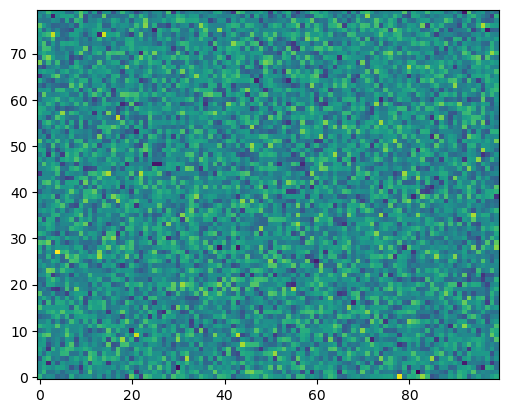

In [ ]:
plt.imshow(t, origin='lower');

## Discriminator

In [ ]:
import nbdev; nbdev.nbdev_export()